# What to expect

In notebook 3A we ran a differential gene expression analysis on the example dataset Schistosoma mansoni and used visualisation techniques to view the most significant genes. In this notebook we will apply the same methods to our choice of dataset in this notebook. We will go on to explore the GO terms and pathways associated with them using online resources.



# Differential Expression analysis

In [1]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# load in the counts and metadata again for your dataset (set the prefix)
prefix = "Plasmodium"
counts = pd.read_csv(f"analysis/{prefix}/star/ReadsPerGene.csv", index_col=0).T
metadata = pd.read_csv(f"data/{prefix}/metadata.csv", index_col=0)

# restrict to the 2 stages we want to compare
counts_s = counts[metadata["timepoint"].isin([16,24]) & metadata["condition"].isin(["wildtype"])]
metadata_s = metadata[metadata["timepoint"].isin([16,24]) & metadata["condition"].isin(["wildtype"])]

# create deseq2 dataset object
dds = DeseqDataSet(
    counts=counts_s,
    metadata=metadata_s,
    design_factors="timepoint",  # compare samples based on the developmental "stage"
    refit_cooks=True
)

# Run DeSeq2
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.41 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 1.49 seconds.

Fitting LFCs...
... done in 0.69 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [2]:
import numpy as np

# Summarize results
stat_res=DeseqStats(dds)
stat_res.summary()
res = stat_res.results_df

# replace p-values of 0 with a very small number as otherwise they cause errors
res.loc[ res.pvalue == 0, "pvalue" ] = np.finfo(np.float64).tiny
res.loc[ res.padj == 0, "padj" ] = np.finfo(np.float64).tiny

Running Wald tests...


Log2 fold change & Wald test p-value: timepoint 24 vs 16
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene                                                                         
PBANKA_0000101      0.499719        0.458866  4.079205  0.112489  0.910436   
PBANKA_0000201      0.000000             NaN       NaN       NaN       NaN   
PBANKA_0000301     10.017695       -0.514198  1.046018 -0.491577  0.623019   
PBANKA_0000401     21.489374        2.099202  0.840283  2.498208  0.012482   
PBANKA_0000600     24.726040       -1.279860  0.682604 -1.874966  0.060797   
...                      ...             ...       ...       ...       ...   
PBANKA_MIT03300     0.000000             NaN       NaN       NaN       NaN   
PBANKA_MIT03400     0.000000             NaN       NaN       NaN       NaN   
PBANKA_MIT03500  4967.510592        1.068291  0.586247  1.822255  0.068416   
PBANKA_MIT03600    80.486185        0.527777  0.587982  0.897607  0.369395   
PBANKA_

... done in 0.40 seconds.



In [3]:
! mkdir -p "analysis/Trypanosoma/de"
! mkdir -p "analysis/Plasmodium/de"

In [4]:
# save this intermediate CSV with a sensible name
comparison = "24_vs_16h_wildtype"
res.to_csv(f"analysis/{prefix}/de/{comparison}.full.csv")

In [5]:
# Filter results with baseMean<10 so that gene expressions close to zero don't skew results
res=res[res.baseMean>=10]

# Filter by padj<=0.05
res=res[res.padj<=0.05]

In [6]:
# Get list of only genes that have an absolute fold change FC > 1.5 and the abs(logFoldChange) > np.log2(1.5)
# You can play with the exact thresholds here, these are just a guide to filter the lists (I've used FC > 2 here!)
sigs=res[abs(res.log2FoldChange)>np.log2(2)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
PBANKA_0000401,21.489374,2.099202,0.840283,2.498208,1.248229e-02,1.649136e-02
PBANKA_0007701,61.267753,2.148695,0.514617,4.175328,2.975570e-05,4.828850e-05
PBANKA_0008101,195.532688,1.897001,0.295428,6.421195,1.352086e-10,2.933319e-10
PBANKA_0100021,1402.834566,3.470364,0.160586,21.610658,1.426008e-103,3.163033e-102
PBANKA_0100041,38.141408,1.635641,0.726573,2.251174,2.437451e-02,3.125623e-02
...,...,...,...,...,...,...
PBANKA_1466121,226.572142,-1.131772,0.267453,-4.231671,2.319611e-05,3.796666e-05
PBANKA_API00095,71.627149,2.234160,0.736168,3.034850,2.406552e-03,3.382129e-03
PBANKA_MIT00800,106.386590,1.004904,0.469661,2.139635,3.238425e-02,4.096592e-02


In [7]:
# Save the up and down regulated genes separately
up = sigs[sigs["log2FoldChange"] > 0]
up.to_csv(f"analysis/{prefix}/de/{comparison}.up.csv")
up

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
PBANKA_0000401,21.489374,2.099202,0.840283,2.498208,1.248229e-02,1.649136e-02
PBANKA_0007701,61.267753,2.148695,0.514617,4.175328,2.975570e-05,4.828850e-05
PBANKA_0008101,195.532688,1.897001,0.295428,6.421195,1.352086e-10,2.933319e-10
PBANKA_0100021,1402.834566,3.470364,0.160586,21.610658,1.426008e-103,3.163033e-102
PBANKA_0100041,38.141408,1.635641,0.726573,2.251174,2.437451e-02,3.125623e-02
...,...,...,...,...,...,...
PBANKA_1465821,17.110991,3.627303,1.050189,3.453951,5.524370e-04,8.235344e-04
PBANKA_API00095,71.627149,2.234160,0.736168,3.034850,2.406552e-03,3.382129e-03
PBANKA_MIT00800,106.386590,1.004904,0.469661,2.139635,3.238425e-02,4.096592e-02


In [8]:
down = sigs[sigs["log2FoldChange"] < 0]
down.to_csv(f"analysis/{prefix}/de/{comparison}.down.csv")
down

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
PBANKA_0100100,201.871191,-2.298185,0.290933,-7.899364,2.803300e-15,7.596516e-15
PBANKA_0100200,1626.922711,-1.330331,0.121823,-10.920171,9.232170e-28,3.962364e-27
PBANKA_0101000,4546.956831,-1.853167,0.126414,-14.659484,1.171605e-48,9.148832e-48
PBANKA_0101300,2578.706476,-1.617343,0.144068,-11.226222,3.031645e-29,1.355417e-28
PBANKA_0102500,1632.255934,-1.323266,0.146632,-9.024398,1.806862e-19,5.847869e-19
...,...,...,...,...,...,...
PBANKA_1465200,340.912963,-1.263252,0.279559,-4.518734,6.221062e-06,1.059000e-05
PBANKA_1465300,462.033479,-1.760952,0.220407,-7.989533,1.354503e-15,3.725427e-15
PBANKA_1465500,138.688469,-1.079225,0.332681,-3.244019,1.178560e-03,1.706972e-03


# Visualisation - Volcano Plot
Following the steps from notebook 3A, create a volcano plot for this dataset, colouring the significant up and down regulated genes. If you chose a different fold change cut off above, use the updated fold change here so you can see which genes are selected for. If desired, you could instead make it interactive with plotly (see extension in 3A).

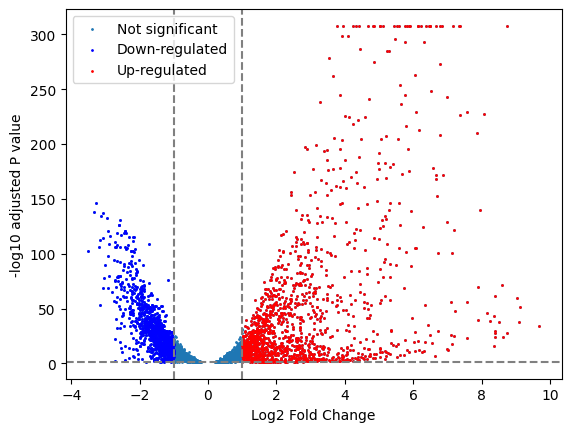

In [10]:
import seaborn as sns
import matplotlib.pylab as plt

# define the significantly up or down regulated genes
down = res[(res['log2FoldChange']<=-np.log2(2))&(res['padj']<0.05)]
up = res[(res['log2FoldChange']>=np.log2(2))&(res['padj']<0.05)]

# plot the all the genes and then highlight downregulated and upregulated
plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=1,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=1,label="Up-regulated",color="red")

#Add axis labels
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10 adjusted P value")

# Add threshold lines
plt.axvline(-np.log2(2),color="grey",linestyle="--")
plt.axvline(np.log2(2),color="grey",linestyle="--")
plt.axhline(-np.log10(0.05),color="grey",linestyle="--")
plt.legend()

plt.savefig('dataset_volcano.png')

# GO Analysis and Metabolic pathways analysis

We will now use these results for GO and metabolic pathway analysis using the [TriTrypDB](https://tritrypdb.org/tritrypdb/app/user/registration) and [PlasmoDB](https://plasmodb.org/plasmo/app/user/registration) websites. Before using these websites you will need to register. Full details of how to do this analysis are in the presentation, but a summary is provided below. 

You are welcome to perform either GO or metabolic pathway analysis on your chosen dataset, or both if you have time.

For these analyses you will need the 2 CSV files of up and down regulated genes which you created above and saved as `analysis/{prefix}/de/{comparison}.up.csv` and `analysis/{prefix}/de/{comparison}.down.csv`. 

## Initial Analysis
First you will "Identify Genes based on List of IDs" by uploading one of the CSV files as a text file to:

https://tritrypdb.org/tritrypdb/app/search/transcript/GeneByLocusTag  
https://plasmodb.org/plasmo/app/search/transcript/GeneByLocusTag

After adding the list of gene IDs, click "Get Answer". 

When the results table appears, you will obtain a list with the organism, gene names (Product description) and genomic locations for the IDs you have introduced. Make sure the box “Show only one transcript per gene” is ticked. This will ensure we do not get duplications. These genes can be explored and the results can be downloaded as a .csv file.

There will now be a tab called "Analyze Results". From this you will be able to select either "Gene Ontology Enrichment" or "Metabolic Pathway Enrichment". Select the GO analysis.

## Gene Ontology Enrichment
This will open up an options page where you can change the parameters for the statistical test it will perform (the defaults are fine). When you are ready, click "Submit". For each GO term, the software will then performs a statistical test to determine if a particular GO term is enriched in your list of genes. 

A table of results will appear reporting each GO term that has been found to be significantly increased in your list. You can download this table, or explore it on the page.

## Metabolic Pathways
This will open up an options page where you can change the parameters for the statistical test it will perform (the defaults are fine). When you are ready, click "Submit". 

A table of results will appear reporting a list of pathways enriched in your dataset along with statistics about the numbers of genes in your list which are associated with it. You can click on a pathway ID to visualise it. You can download this results table, or explore it on the page.